[View in Colaboratory](https://colab.research.google.com/github/hkhare42/dataviz/blob/master/fantasywc2018_viz.ipynb)

In [1]:
!pip install --upgrade -q gspread

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install git+https://github.com/mwaskom/seaborn.git

  Cloning https://github.com/mwaskom/seaborn.git to /tmp/pip-req-build-agueksxc
  Running setup.py bdist_wheel for seaborn ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-ult1kver/wheels/4e/57/af/138c7bf2390a67f7010588cf080fb8b4e741bb290c2ad12018
Successfully built seaborn
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns

import gspread
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Connect to Google Sheets and authenticate user
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
# Open relevant sheet and read data.
worksheet = gc.open('fantasy wc 2018').sheet1
rows = worksheet.get_all_values()

# Convert to a Pandas DataFrame
df = (pd.DataFrame.from_records(rows, 
                                columns=['Team','Owner','MatchDay',
                                         'Points','Booster'])
      .drop(0)
      .reset_index(drop=True))

In [6]:
df.head()

,Team,Owner,MatchDay,Points,Booster
0,Schwifty Squanchers,Harshit,RD 1,72,BB
1,Schwifty Squanchers,Harshit,RD 2,70,
2,Schwifty Squanchers,Harshit,RD 3,29,
3,Schwifty Squanchers,Harshit,RO 16,38,
4,GrintaXI,Kartik,RD 1,65,


In [7]:
df.dtypes

Team        object
Owner       object
MatchDay    object
Points      object
Booster     object
dtype: object

In [0]:
df.loc[:, 'MatchDay'] = (df.MatchDay
                         .str.strip()
                         .astype(
                             CategoricalDtype(
                                    categories=['TPA*','RD 1','RD 2','RD 3',
                                                'RO 16','QF','SF','F']
                                 ,ordered=True)))

df.loc[:, 'Points'] = df.Points.astype(int)
df.loc[:, 'Cumulative Points'] = (df.sort_values('MatchDay')
                                  .groupby(['Team'])
                                  ['Points'].cumsum())
df.loc[:, 'BB_Flag'] = df['Cumulative Points'].where(df.Booster == 'BB', None)
df.loc[:, 'MC_Flag'] = df['Cumulative Points'].where(df.Booster == 'MC', None)
df.loc[:, 'BB_Flag_md'] = df['Points'].where(df.Booster == 'BB', None)
df.loc[:, 'MC_Flag_md'] = df['Points'].where(df.Booster == 'MC', None)

In [0]:
# Variables required for annotating graphs
rounds = len(pd.unique(df.MatchDay)) - 1
current_points = df.groupby('Team')['Cumulative Points'].max().to_dict()

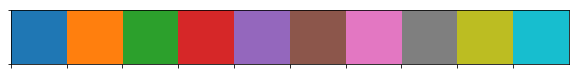

In [10]:
# Decide on a palette for plotting
current_palette = sns.color_palette('tab10', 10)
sns.palplot(current_palette)
sns.set_palette('tab10', 10)

In [0]:
sns.set_style('whitegrid')

### **Worm-chart: Cumulative Points at the end of each round**

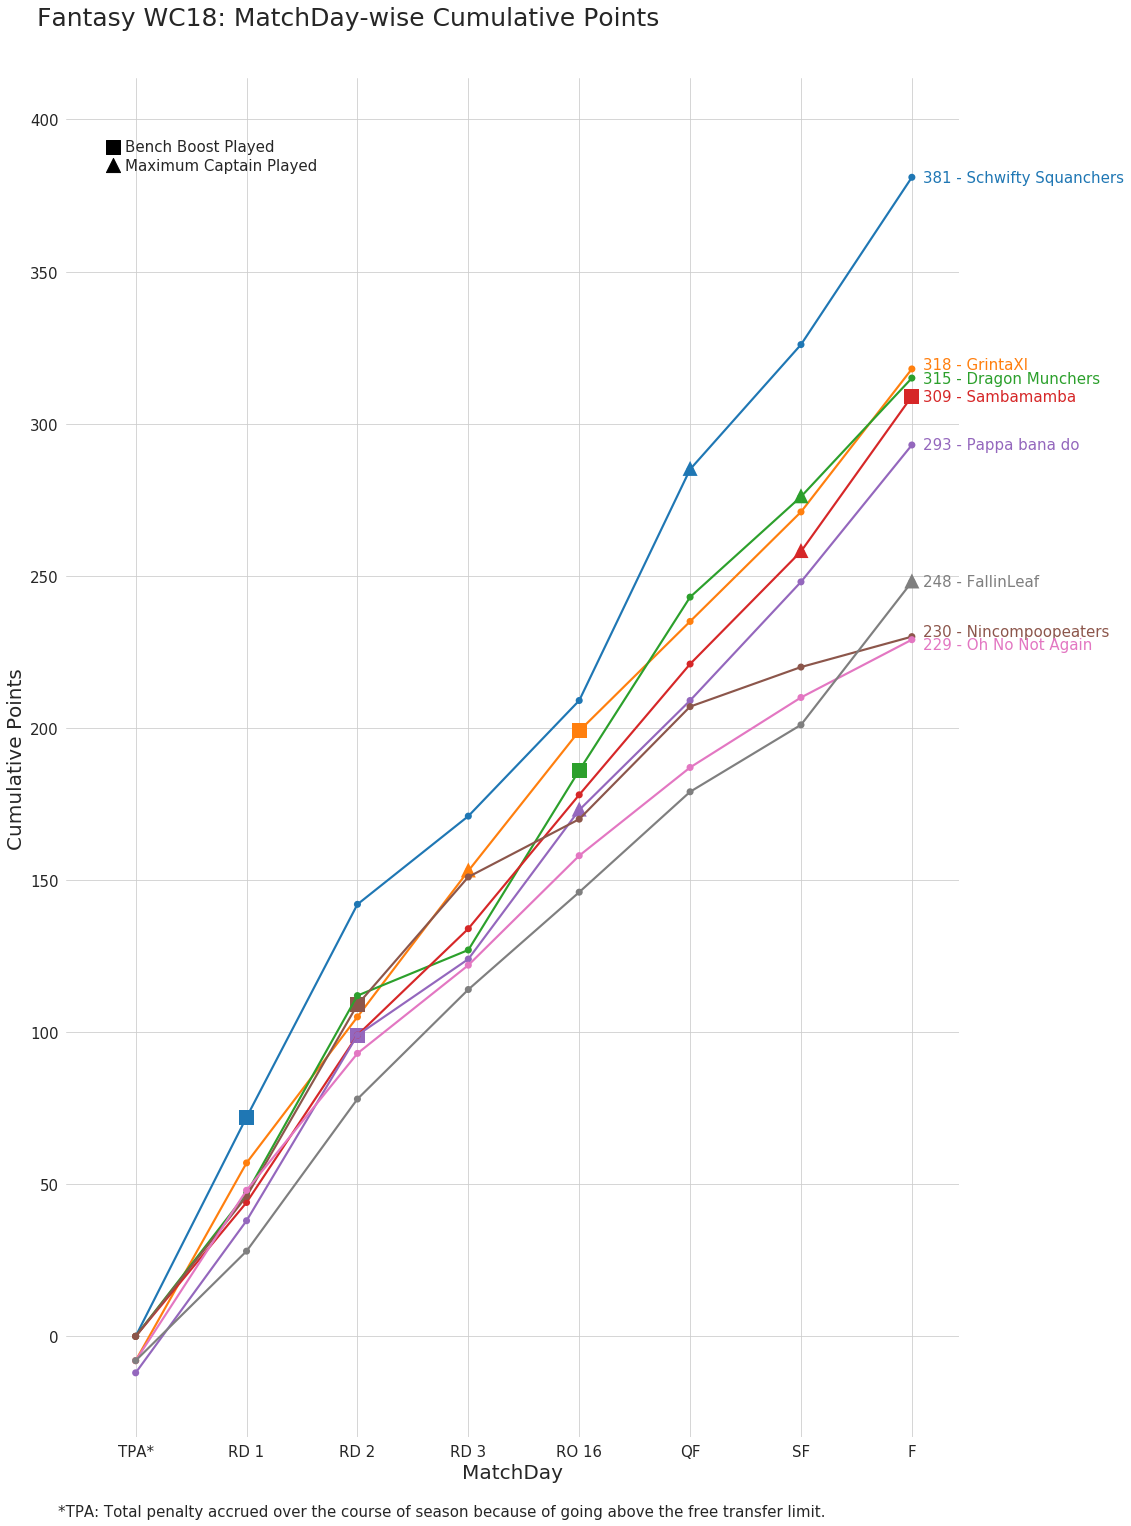

In [12]:
fig, ax = plt.subplots(figsize=(16, 25))

sns.stripplot(data=df, x='MatchDay', y='BB_Flag', hue='Team',
              size=15, marker='s', jitter=False, ax=ax)
sns.stripplot(data=df, x='MatchDay', y=df.MC_Flag + .3, hue='Team', 
              size=15, marker='^', jitter=False, ax=ax)
sns.pointplot(data=df, x='MatchDay', y='Cumulative Points', hue='Team',
              scale=0.8, jitter=False, ax=ax)

ax.grid(True)
sns.despine(left=True, bottom=True)
ax.set_ylabel('Cumulative Points')

# Customizing annotations to reduce overlap
text_pos = current_points.copy()
for idx, team in enumerate(pd.unique(df.Team)):
    if team == 'GrintaXI':
        text_pos[team] += 1.5
    if team == 'Nincompoopeaters':
        text_pos[team] += 1.75
    if team == 'Oh No Not Again':
        text_pos[team] -= 1.75
        
    ax.text(rounds+0.1, text_pos[team], 
            '{} - {}'.format(current_points[team], team),
           color=current_palette[idx],
           va='center',
           fontsize=15)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)

ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
ax.legend().set_visible(False)

# Custom legend for Boosters
ax.scatter(-0.2, max(current_points.values())+10, marker='s',
           s=200, color='black')
ax.scatter(-0.2, max(current_points.values())+4, marker='^',
           s=200, color='black')
ax.text(-0.1, max(current_points.values())+10, 'Bench Boost Played',
        va='center', fontsize=15)
ax.text(-0.1, max(current_points.values())+4, 'Maximum Captain Played',
        va='center', fontsize=15)

ax.text(-0.7,-59, "*TPA: Total penalty accrued over the course of season "
        "because of going above the free transfer limit.",
       fontsize=15)
    
fig.suptitle('Fantasy WC18: MatchDay-wise Cumulative Points', x=0.1, y=0.92, 
             ha='left', fontsize=25)
plt.savefig('mdwise_cumulative.png', bbox_inches='tight', pad_inches=1)

### **Points scored in each round**

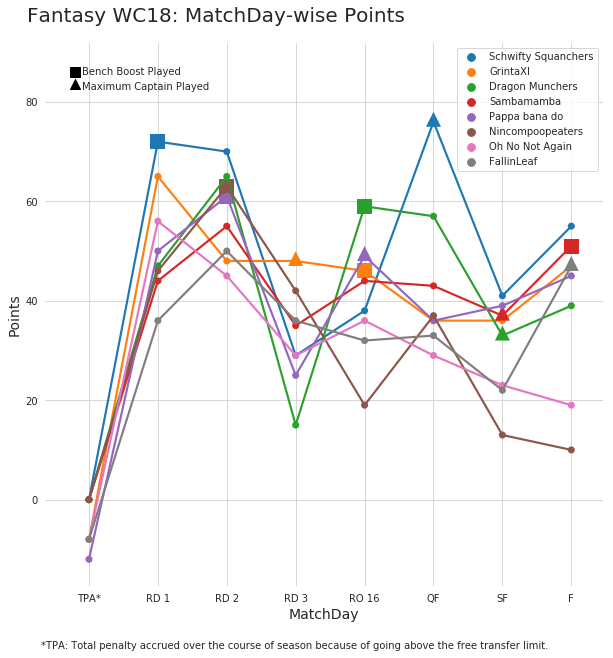

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.stripplot(data=df, x='MatchDay', y='BB_Flag_md', hue='Team',
              size=15, marker='s', jitter=False, ax=ax)
sns.stripplot(data=df, x='MatchDay', y=df.MC_Flag_md + .5, hue='Team',
              size=15, marker='^', jitter=False, ax=ax)
sns.pointplot(data=df, x='MatchDay', y='Points', hue='Team', 
              scale=.8, jitter=False, ax=ax)

ax.grid(True)
sns.despine(left=True, bottom=True)

ax.text(-0.7,-30, "*TPA: Total penalty accrued over the course of season "
        "because of going above the free transfer limit.",
       fontsize=10)
ax.set_ylabel('Points', fontsize=14)
ax.set_xlabel('MatchDay', fontsize=14)

# Handling labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:8], labels[:8], frameon=True)

ax.scatter(-0.2, max(df.Points)+10, marker='s', s=100, color='black')
ax.scatter(-0.2, max(df.Points)+7.5, marker='^', s=100, color='black')
ax.text(-0.1, max(df.Points)+10, 'Bench Boost Played',
        va='center', fontsize=10)
ax.text(-0.1, max(df.Points)+7, 'Maximum Captain Played', 
        va='center', fontsize=10)

fig.suptitle('Fantasy WC18: MatchDay-wise Points', x=0.1, y=0.93, ha='left', fontsize=20)
plt.savefig('mdwise_pts.png', bbox_inches='tight', pad_inches=0.5)

### **Stacked bar view of points scored in each round**

In [0]:
# Reshape data into form required for plotting stacked bar chart
cross_view = (pd.crosstab(df.Team, df.MatchDay, values=df['Points'], 
                         aggfunc='sum', margins=True)
             .iloc[:-1,:]
             .sort_values('All'))

In [15]:
cross_view

MatchDay,TPA*,RD 1,RD 2,RD 3,RO 16,QF,SF,F,All
Team,,,,,,,,,
Oh No Not Again,-8,56,45,29,36,29,23,19,229
Nincompoopeaters,0,46,63,42,19,37,13,10,230
FallinLeaf,-8,36,50,36,32,33,22,47,248
Pappa bana do,-12,50,61,25,49,36,39,45,293
Sambamamba,0,44,55,35,44,43,37,51,309
Dragon Munchers,0,47,65,15,59,57,33,39,315
GrintaXI,-8,65,48,48,46,36,36,47,318
Schwifty Squanchers,0,72,70,29,38,76,41,55,381


In [0]:
# Create dict to store y coordinates for each team
team_y_loc = {team:idx for idx, team in enumerate(cross_view.index)}

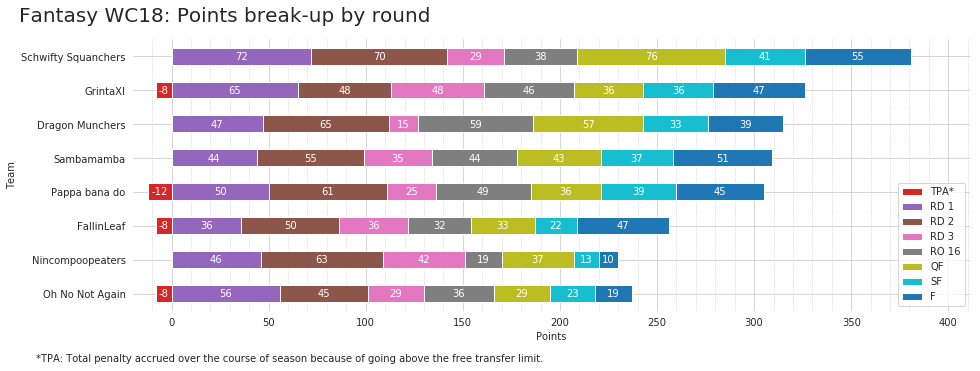

In [17]:
# Re-order palette colors such that Red comes first
# Red signifies the penalty score accrued by each team
sns.set_palette(sns.color_palette('tab10', 10)[3:] 
                + sns.color_palette('tab10', 10)[:3])

fig, ax = plt.subplots(figsize=(15,5))

(cross_view
 .iloc[:,:-1]
 .plot.barh(stacked=True, ax=ax))

ax.set_xlim(-20,411)
ax.xaxis.grid(b=True, linestyle=':', which='minor')
ax.minorticks_on()

ax.legend(frameon=True)

# Adding annotations to bar plot
for idx, row in df[df.MatchDay != 'TPA*'].iterrows():
  ax.text((row['Cumulative Points'] 
            - row['Points']/2 
            - (df.loc[
                (df.Team == row['Team']) & (df.MatchDay == 'TPA*') , 'Points']
               .values[0])), 
          team_y_loc[row['Team']], 
          row['Points'],
          va='center',
          ha='center',
          color='white')
  
for idx, row in df[df.MatchDay == 'TPA*'].iterrows():
  if row['Points'] != 0:
     ax.text(row['Points']/2, team_y_loc[row['Team']], row['Points'],
              va='center',
              ha='center',
              color='white')

ax.set_xlabel('Points')
      
sns.despine(left=True,bottom=True)

ax.text(-70, -2, "*TPA: Total penalty accrued over the course of season "
        "because of going above the free transfer limit.",
       fontsize=10)

fig.suptitle('Fantasy WC18: Points break-up by round', 
             x=0.02, y=0.97, ha='left', fontsize=20)
plt.savefig('pts_breakup_byround.png', bbox_inches='tight', pad_inches=0.5)

In [0]:
from google.colab import files

files.download('mdwise_pts.png')
files.download('mdwise_cumulative.png')
files.download('pts_breakup_byround.png')